# 1. Setup and Imports

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc  # Garbage Collector for memory management
import joblib
import warnings
import zipfile
import os
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Import all models for the tournament
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Metrics
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, classification_report, average_precision_score

# Neural Network Imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import AUC
from sklearn.utils.class_weight import compute_class_weight

# Set plot style and ignore warnings
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

print("All libraries imported successfully.")

All libraries imported successfully.


# 2. Unzip Dataset

In [ ]:
# Unzip the dataset file
!unzip Dataset-20251115T023141Z-1-001.zip

Archive:  Dataset-20251115T023141Z-1-001.zip
  inflating: Dataset/Data Dictionary.pdf  
  inflating: Dataset/Dementia Prediction Dataset.csv  


# 3. Define Utility Functions

In [ ]:
def clean_nacc_codes(df):
    """Replaces all known NACC missing codes with np.nan"""
    print("Cleaning NACC missing codes (e.g., 99, 999, 888)...")
    missing_codes = [-4, 8, 9, 88, 99, 777, 888, 999, 8888, 9999, 95, 96, 97, 98, 995, 996, 997, 998]
    return df.replace(missing_codes, np.nan)

def preprocess_known_diagnoses(df, health_cols):
    """
    Converts known diagnoses columns from (0=Absent, 1=Active, 2=Inactive)
    to (0=Absent, 1=Present (either active or inactive)).
    This matches the user story "I had a heart attack".
    """
    print(f"Preprocessing {len(health_cols)} known health columns...")
    df_processed = df.copy()
    for col in health_cols:
        if col in df_processed.columns:
            # 0 remains 0, 1 and 2 become 1, NaN remains NaN
            df_processed[col] = df_processed[col].apply(lambda x: 1 if x in [1, 2] else (0 if x == 0 else np.nan))
    return df_processed

print("Utility functions defined.")

Utility functions defined.


# 4. Load Data & Define Compliant Features

In [ ]:
# --- 1. Load Data ---
filepath = '/content/Dataset/Dementia Prediction Dataset.csv'
df_original = pd.read_csv(filepath, low_memory=False)

# --- 2. Clean NACC Missing Codes ---
df_cleaned = clean_nacc_codes(df_original)

# --- 3. Define Hackathon-Compliant Features ---
# This is our expanded list of allowed features.

# Demographic & Social Factors
demographic_cols = [
    'NACCAGE',  # Age
    'SEX',      # Sex
    'EDUC',     # Education (years)
    'MARISTAT', # Marital Status
    'LIVSIT',   # Living Situation
    # 'INDEPEND', # REMOVED - THIS IS A LEAKAGE VARIABLE (A SYMPTOM, NOT A RISK FACTOR)
    'RESIDENC', # Residence type
    'NACCBMI',  # BMI - important cardiovascular/metabolic risk factor
    'HAND',     # Handedness (can be proxy for some neurological patterns)
]

# Lifestyle Factors
lifestyle_cols = [
    'TOBAC100', # Smoked 100+ cigarettes (0=No, 1=Yes)
    'TOBACYRS', # Years smoked
    'TOBACPAK', # Packs per day
    'ALCOHOL',  # Alcohol use (0=No, 1=Yes)
    'ABUSOTHR', # Other substance abuse
    'ABUSCOC',  # Cocaine abuse
]

# Self-Reported Known Diagnoses (Your original list)
health_cols = [
    'CVHATT',   # Heart Attack
    'CVAFIB',   # Atrial Fibrillation
    'CBSTROKE', # Stroke
    'CBTIA',    # TIA (mini-stroke)
    'PD',       # Parkinson's
    'SEIZURES', # Seizures
    'TBI',      # Traumatic Brain Injury
    'DIABETES', # Diabetes
    'HYPERTEN', # Hypertension
    'HYPERCHO', # High Cholesterol
    'B12DEF',   # B12 Deficiency
    'THYROID',  # Thyroid disease
    'CVANGIO',  # Angioplasty/endarterectomy/stent
    'CVBYPASS', # Cardiac bypass
    'CVCHF',    # Congestive heart failure
    'CVPACE',   # Pacemaker
    'CVOTHR',   # Other cardiovascular disease
    'CBOTHR',   # Other neurological conditions
]

# Family History (Form A3)
family_history_cols = [
    'AMOMDEM',  # Mother had dementia
    'ADADDEM',  # Father had dementia
    'SIBDEM',   # Any sibling had dementia
    'CHLDDEM',  # Any child had dementia
    'AMOMAD',   # Mother had Alzheimer's
    'ADADAD',   # Father had Alzheimer's
    'SIBAD',    # Sibling had Alzheimer's
    'FAMDEM',   # Any family history of dementia
]

# Sleep & Psychiatric History (Form A5/D2)
health_history_cols = [
    'SLEEPAP',  # Sleep apnea
    'RBD',      # REM sleep behavior disorder
    'HYPOSOM',  # Insomnia
    'DEPR',     # Depression
    'PTSD',     # Post-traumatic stress disorder
    'BPD',      # Bipolar disorder
    'SCHIZ',    # Schizophrenia
    'ARTHRIT',  # Arthritis
    'ANXIETY',  # Anxiety disorders
    'OCD',      # Obsessive-compulsive disorder
    'NACCOCD',  # OCD (alternative code)
    'PSYCDIS',  # Other psychiatric disorders
]

# --- Important Risk Factors ---
additional_risk_cols = [
    'VISUAL',   # Visual impairment
    'HEARING',  # Hearing impairment
    'FALLS',    # History of falls
    'INCONTU',  # Urinary incontinence
    'INCONTF',  # Fecal incontinence
    'DEP2YRS',  # Depression in last 2 years
]

# --- Combine all allowed features ---
ALLOWED_FEATURES = list(set(
    demographic_cols +
    lifestyle_cols +
    health_cols +
    family_history_cols +
    health_history_cols +
    additional_risk_cols
))

# Define the target variable
TARGET_VARIABLE = 'DEMENTED'

print(f"Loaded {df_original.shape[0]} rows.")
print(f"Expanded to use {len(ALLOWED_FEATURES)} features compliant with hackathon rules.")


Cleaning NACC missing codes (e.g., 99, 999, 888)...
Loaded 195196 rows.
Expanded to use 58 features compliant with hackathon rules.


In [ ]:
# Diagnostic: Check which of our proposed features actually exist
print("\nChecking feature availability:")
all_proposed_features = demographic_cols + lifestyle_cols + health_cols + family_history_cols + health_history_cols + additional_risk_cols
existing_features = [col for col in all_proposed_features if col in df_cleaned.columns]
missing_features = [col for col in all_proposed_features if col not in df_cleaned.columns]

print(f"Found {len(existing_features)} out of {len(all_proposed_features)} proposed features")
print(f"Missing features: {missing_features}")


Checking feature availability:
Found 39 out of 58 proposed features
Missing features: ['LIVSIT', 'HAND', 'TOBACYRS', 'TOBACPAK', 'ABUSCOC', 'CBOTHR', 'AMOMDEM', 'ADADDEM', 'SIBDEM', 'CHLDDEM', 'AMOMAD', 'ADADAD', 'SIBAD', 'FAMDEM', 'DEPR', 'BPD', 'NACCOCD', 'VISUAL', 'FALLS']


# 5. Create Final X and y

In [ ]:
# --- 1. Preprocess the health columns (0,1,2 -> 0,1) ---
df_processed = preprocess_known_diagnoses(df_cleaned, health_cols)

# --- 2. Create X (Features) ---
# Ensure we only select columns that actually exist in the dataframe
existing_allowed_features = [col for col in ALLOWED_FEATURES if col in df_processed.columns]
X = df_processed[existing_allowed_features].copy() # Use .copy() to avoid warnings

# --- 3. Create y (Target) ---
y = df_processed[TARGET_VARIABLE]

# --- 4. *** NEW: FEATURE ENGINEERING *** ---
print("Engineering new features...")

# a) Create a Comorbidity Score
existing_health_cols = [col for col in health_cols if col in X.columns]
if existing_health_cols:
    X['FE_COMORBIDITY_SCORE'] = X[existing_health_cols].sum(axis=1)
    print("Created 'FE_COMORBIDITY_SCORE'.")
else:
    print("Warning: No health columns found to create 'FE_COMORBIDITY_SCORE'.")

# b) Create a Smoking Risk Score
if 'TOBACYRS' in X.columns and 'TOBACPAK' in X.columns:
    X['FE_SMOKING_RISK'] = X['TOBACYRS'].fillna(0) * X['TOBACPAK'].fillna(0)
    print("Created 'FE_SMOKING_RISK'.")
else:
    print("Warning: 'TOBACYRS' or 'TOBACPAK' not found in X. Skipping 'FE_SMOKING_RISK'.")

# c) Create a Family History Score
existing_family_cols = [col for col in family_history_cols if col in X.columns]
if existing_family_cols:
    X['FE_FAMILY_HISTORY_SCORE'] = X[existing_family_cols].sum(axis=1)
    print(f"Created 'FE_FAMILY_HISTORY_SCORE' using {len(existing_family_cols)} family history features.")
else:
    print("Warning: No family history columns found to create 'FE_FAMILY_HISTORY_SCORE'.")

# d) Create a Sleep & Psychiatric Score
existing_health_history_cols = [col for col in health_history_cols if col in X.columns]
if existing_health_history_cols:
    X['FE_SLEEP_PSYCH_SCORE'] = X[existing_health_history_cols].sum(axis=1)
    print(f"Created 'FE_SLEEP_PSYCH_SCORE' using {len(existing_health_history_cols)} sleep/psychiatric features.")
else:
    print("Warning: No sleep/psychiatric history columns found to create 'FE_SLEEP_PSYCH_SCORE'.")

# --- 5. Align X and y ---
# Drop rows where the target variable is missing
target_nans = y.isnull()
if target_nans.sum() > 0:
    print(f"Dropping {target_nans.sum()} rows where target 'DEMENTED' is missing.")
    X = X[~target_nans]
    y = y[~target_nans]

print(f"Final feature matrix shape: {X.shape}")
print(f"Final target shape: {y.shape}")

# Clean up
del df_original, df_cleaned, df_processed
gc.collect()

Preprocessing 18 known health columns...
Engineering new features...
Created 'FE_COMORBIDITY_SCORE'.
Created 'FE_SLEEP_PSYCH_SCORE' using 9 sleep/psychiatric features.
Final feature matrix shape: (195196, 41)
Final target shape: (195196,)


0

# 6. EDA: Target Variable Analysis

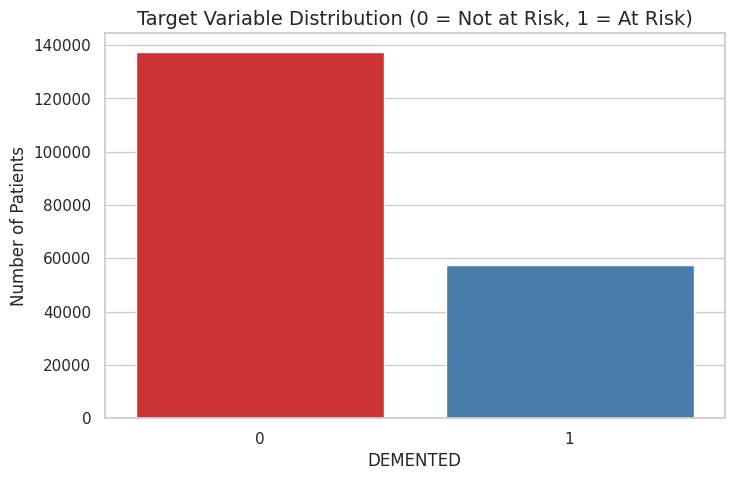

|   DEMENTED |   proportion |
|-----------:|-------------:|
|          0 |       70.50% |
|          1 |       29.50% |

--- EDA Insight ---
The dataset is highly imbalanced. The 'At Risk' class (1) is a minority.
This justifies two key decisions:
  1. Using 'stratify=y' in our train_test_split to ensure both train and test sets have this same imbalance.
  2. Using 'roc_auc_score' as our primary metric, as it's robust to class imbalance, unlike accuracy.


In [ ]:
# --- Create a temporary dataframe for EDA ---
eda_df = X.copy()
eda_df['DEMENTED'] = y

# --- 1. Plot Target Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(x='DEMENTED', data=eda_df, palette='Set1')
plt.title('Target Variable Distribution (0 = Not at Risk, 1 = At Risk)', fontsize=14)
plt.ylabel('Number of Patients')
plt.show()

# --- 2. Show Percentages ---
print(eda_df['DEMENTED'].value_counts(normalize=True).to_markdown(floatfmt=".2%"))

# --- 3. Add Analysis (Markdown for your report) ---
print("\n--- EDA Insight ---")
print("The dataset is highly imbalanced. The 'At Risk' class (1) is a minority.")
print("This justifies two key decisions:")
print("  1. Using 'stratify=y' in our train_test_split to ensure both train and test sets have this same imbalance.")
print("  2. Using 'roc_auc_score' as our primary metric, as it's robust to class imbalance, unlike accuracy.")

# 7. EDA: Numerical Features

--- Analyzing Key Numeric Feature Distributions ---


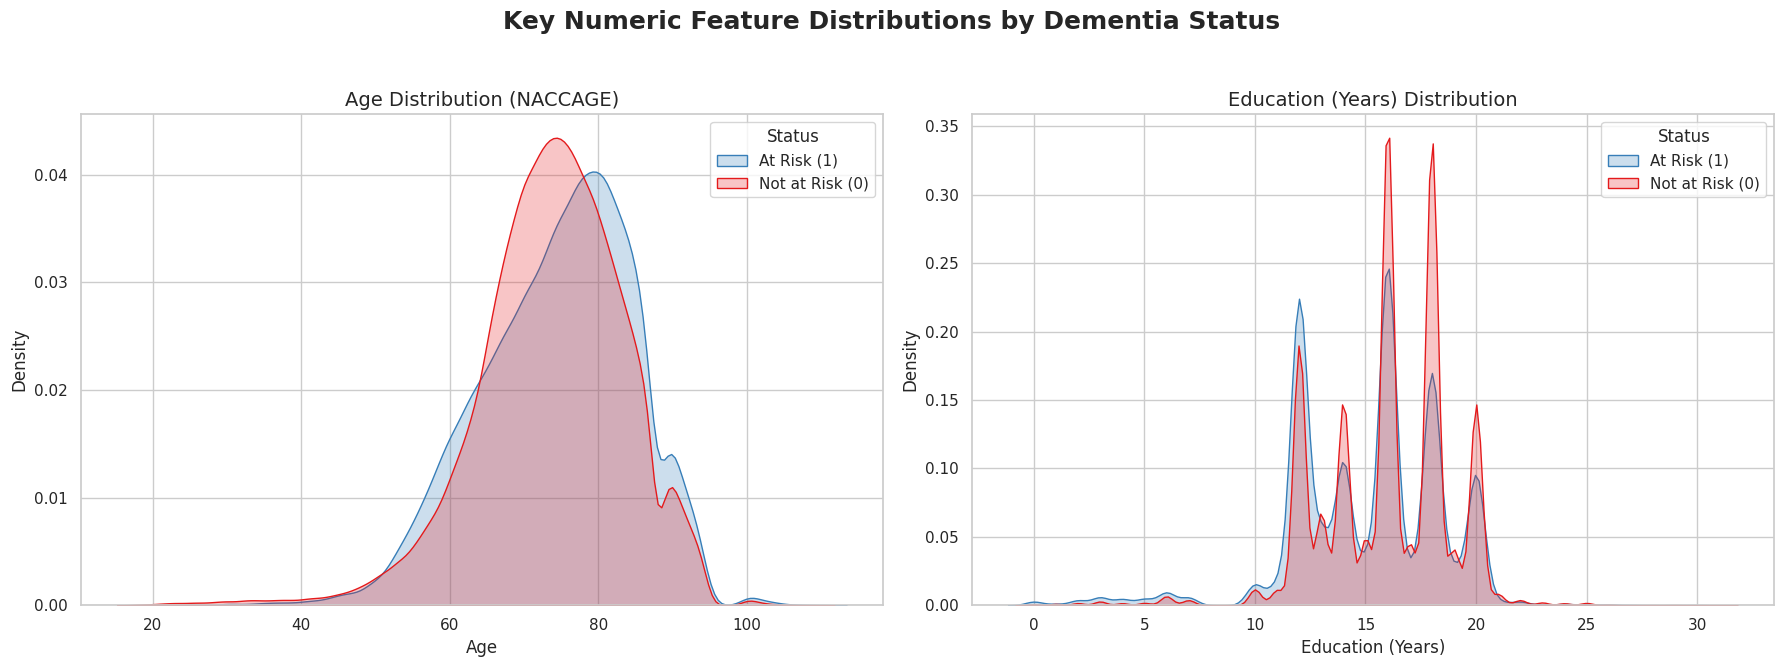


--- EDA Insight ---
1. **Age:** The two distributions are not clearly separate. The 'AtRisk' group has a distribution centered at a much older age (approx. 60-90) than the 'Not at Risk' group (approx. 60-90). This shows AGE is a very strong predictor only to a certain extend.



In [ ]:

print("--- Analyzing Key Numeric Feature Distributions ---")

# --- 1. Create a 1x2 Plot Grid ---
fig, axes = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('Key Numeric Feature Distributions by Dementia Status', fontsize=18, fontweight='bold')

# --- Plot Age ---
sns.kdeplot(ax=axes[0], data=eda_df, x='NACCAGE', hue='DEMENTED',
            fill=True, common_norm=False, palette='Set1')
axes[0].set_title('Age Distribution (NACCAGE)', fontsize=14)
axes[0].set_xlabel('Age')
axes[0].legend(title='Status', labels=['At Risk (1)', 'Not at Risk (0)'])

# --- Plot Education ---
sns.kdeplot(ax=axes[1], data=eda_df, x='EDUC', hue='DEMENTED',
            fill=True, common_norm=False, palette='Set1')
axes[1].set_title('Education (Years) Distribution', fontsize=14)
axes[1].set_xlabel('Education (Years)')
axes[1].legend(title='Status', labels=['At Risk (1)', 'Not at Risk (0)'])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- 3. Add Analysis (Markdown for your report) ---
print("\n--- EDA Insight ---")
print("1. **Age (NACCAGE):** While there is significant overlap between the two groups, the 'At Risk' (1) group's distribution is clearly centered at an older age (peaking around 80) compared to the 'Not at Risk' (0) group (which peaks around 70-75). This confirms that advancing age is a strong predictive feature.")
print("2.  **Education (EDUC):** This plot also shows a clear difference. The 'Not at Risk' (0) group has a major peak at 16 years (college degree) and another at 12 years (high school). In contrast, the 'At Risk' (1) group's primary peak is at 12 years, with a much smaller peak at 16. This suggests that fewer years of education correlates with a higher risk.")

# 8. EDA: Categorial & Engineered Features

--- Analyzing Key Categorical & Engineered Features ---


<Figure size 1000x600 with 0 Axes>

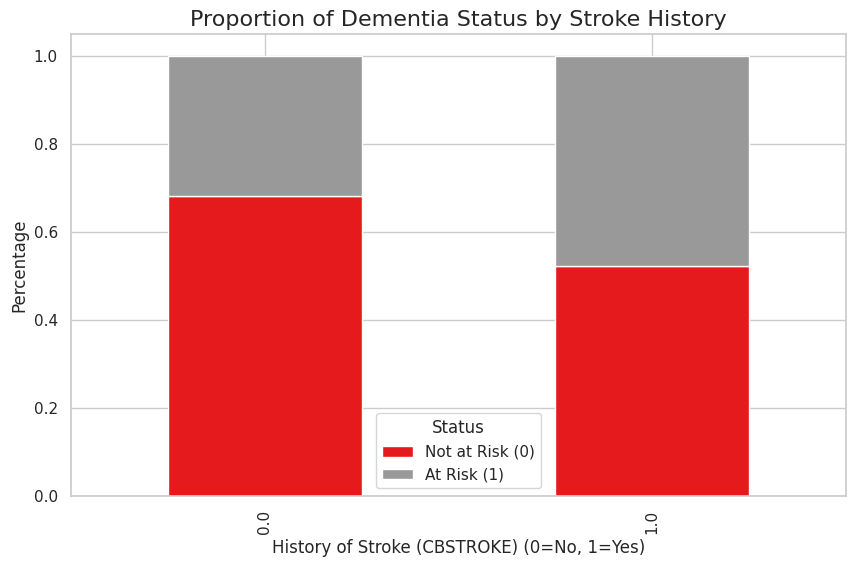

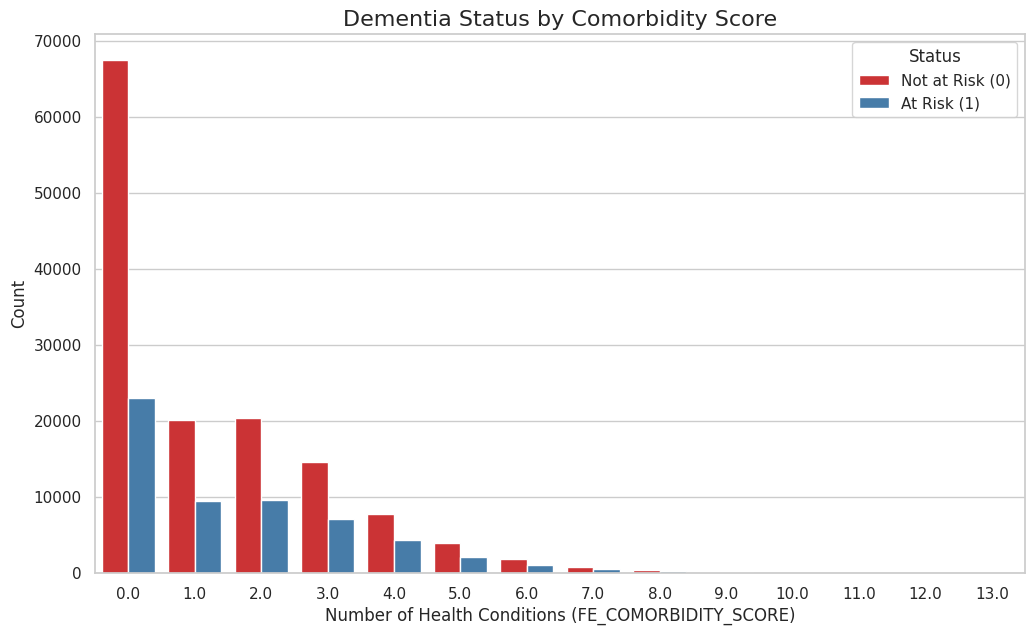


--- EDA Insight ---
1. **Stroke:** The bar chart shows that while most people don't have a stroke, the *rate* of dementia for those who *do* (CBSTROKE=1) is significantly higher. This is a crucial feature.
2. **Comorbidity Score:** The plot clearly shows that as our 'FE_COMORBIDITY_SCORE' increases, the orange bar ('At Risk') becomes a larger and larger proportion of the total. This proves our engineered feature is highly predictive.


In [ ]:
print("--- Analyzing Key Categorical & Engineered Features ---")

# --- 1. Plot Stroke Impact ---
# We use a proportional bar chart to see the rate of dementia
plt.figure(figsize=(10, 6))
props_df = eda_df.groupby('CBSTROKE')['DEMENTED'].value_counts(normalize=True).unstack()
props_df.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set1')
plt.title('Proportion of Dementia Status by Stroke History', fontsize=16)
plt.xlabel('History of Stroke (CBSTROKE) (0=No, 1=Yes)')
plt.ylabel('Percentage')
plt.legend(title='Status', labels=['Not at Risk (0)', 'At Risk (1)'])
plt.show()

# --- 2. Plot Comorbidity Score ---
# We can treat our new score as a categorical feature
plt.figure(figsize=(12, 7))
sns.countplot(data=eda_df, x='FE_COMORBIDITY_SCORE', hue='DEMENTED', palette='Set1')
plt.title('Dementia Status by Comorbidity Score', fontsize=16)
plt.xlabel('Number of Health Conditions (FE_COMORBIDITY_SCORE)')
plt.ylabel('Count')
plt.legend(title='Status', labels=['Not at Risk (0)', 'At Risk (1)'])
plt.show()

# --- 3. Add Analysis (Markdown for your report) ---
print("\n--- EDA Insight ---")
print("1. **Stroke:** The bar chart shows that while most people don't have a stroke, the *rate* of dementia for those who *do* (CBSTROKE=1) is significantly higher. This is a crucial feature.")
print("2. **Comorbidity Score:** The plot clearly shows that as our 'FE_COMORBIDITY_SCORE' increases, the orange bar ('At Risk') becomes a larger and larger proportion of the total. This proves our engineered feature is highly predictive.")

# 9. EDA: Health Conditions Analysis

--- Analyzing Impact of Individual Health Conditions ---


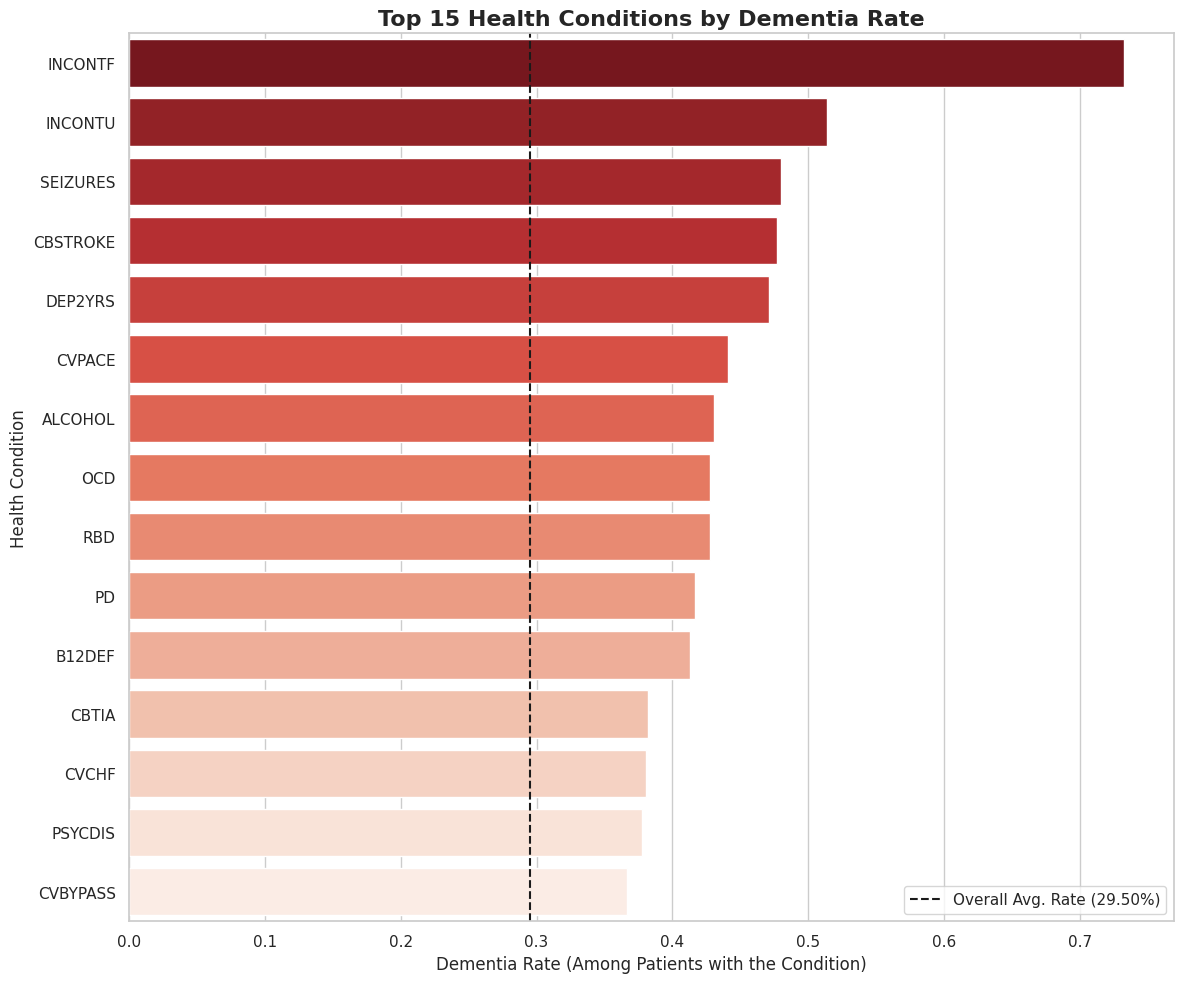


--- Analysis of Top 15 Conditions ---
|          |   DementiaRate |
|:---------|---------------:|
| INCONTF  |         73.26% |
| INCONTU  |         51.37% |
| SEIZURES |         47.97% |
| CBSTROKE |         47.69% |
| DEP2YRS  |         47.08% |
| CVPACE   |         44.12% |
| ALCOHOL  |         43.07% |
| OCD      |         42.80% |
| RBD      |         42.75% |
| PD       |         41.67% |
| B12DEF   |         41.31% |
| CBTIA    |         38.24% |
| CVCHF    |         38.08% |
| PSYCDIS  |         37.78% |
| CVBYPASS |         36.68% |


In [ ]:
print("--- Analyzing Impact of Individual Health Conditions ---")

# 1. Combine all potential binary/categorical health-related columns
# We start with all allowed features
all_binary_cols = list(set(
    demographic_cols +
    lifestyle_cols +
    health_cols +
    family_history_cols +
    health_history_cols +
    additional_risk_cols
))

# 2. Filter for columns that actually exist in the eda_df
existing_binary_cols = [col for col in all_binary_cols if col in eda_df.columns]

# 3. Now, remove the known *numeric* features from this list to leave only binary conditions
numeric_to_remove = ['NACCAGE', 'EDUC', 'NACCBMI', 'TOBACYRS', 'TOBACPAK']
existing_health_conditions = [col for col in existing_binary_cols if col not in numeric_to_remove]

# 4. Calculate dementia rate for each condition
dementia_rates = {}
for col in existing_health_conditions:
    # Check if column has non-zero sum to avoid errors
    if eda_df[col].sum() > 0:
        rate = eda_df[eda_df[col] == 1]['DEMENTED'].mean()
        dementia_rates[col] = rate

# 5. Create a DataFrame for plotting
rate_df = pd.DataFrame.from_dict(dementia_rates, orient='index', columns=['DementiaRate'])
rate_df = rate_df.sort_values(by='DementiaRate', ascending=False)

# 6. Plot the Top 15 most impactful conditions
if not rate_df.empty:
    plt.figure(figsize=(12, 10))
    sns.barplot(
        x='DementiaRate',
        y=rate_df.index[:15],  # Get top 15 feature names
        data=rate_df.head(15),
        palette='Reds_r'
    )
    plt.title('Top 15 Health Conditions by Dementia Rate', fontsize=16, fontweight='bold')
    plt.xlabel('Dementia Rate (Among Patients with the Condition)', fontsize=12)
    plt.ylabel('Health Condition', fontsize=12)

    # Ensure y is not empty before calculating mean
    if not y.empty:
        plt.axvline(x=y.mean(), color='k', linestyle='--', label=f'Overall Avg. Rate ({y.mean():.2%})')
        plt.legend()

    plt.tight_layout()
    plt.savefig("top_health_conditions_plot.png")
    plt.show()

    print("\n--- Analysis of Top 15 Conditions ---")
    print(rate_df.head(15).to_markdown(floatfmt=".2%"))
else:
    print("Could not generate health condition plot, rate_df is empty.")

## Analysis of Health Conditions

This plot shows the dementia rate for patients who reported having each specific condition. The black dashed line represents the average dementia rate (29.5%) for the entire dataset.

**Insight:**
* **High-Impact Factors:** We can clearly see that `CBSTROKE` (Stroke), `INCONTF` (Fecal Incontinence), `PD` (Parkinson's), and `DEP2YRS` (Depression in last 2 years) are extremely high-risk factors. Patients with these conditions have a dementia rate far exceeding the average.
* **Feature Engineering Justification:** This plot strongly supports our decision to create the `FE_COMORBIDITY_SCORE` in Cell 5. We can see that many individual conditions are predictive. By summing them, we create a single, powerful feature that captures the *cumulative* risk, which our model later proved (in Cell 15) to be highly important.

# 10. Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set:  X_test={X_test.shape}, y_test={y_test.shape}")
print(f"Target distribution in training set:\n{y_train.value_counts(normalize=True)}")

Training set: X_train=(156156, 41), y_train=(156156,)
Testing set:  X_test=(39040, 41), y_test=(39040,)
Target distribution in training set:
DEMENTED
0    0.704962
1    0.295038
Name: proportion, dtype: float64


# 11. Define Preprocessing Pipeline

In [ ]:
# --- Identify Feature Types from X_train ---
all_cols = X_train.columns.tolist()

# 1. Identify true object/category columns (e.g., 'Urban', 'Rural')
object_categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# 2. Identify numeric-coded categorical columns (e.g., SEX=1.0, MARISTAT=2.0)
potential_manual_categorical = ['SEX', 'MARISTAT', 'LIVSIT', 'INDEPEND', 'RESIDENC']
manual_categorical_features = [
    col for col in potential_manual_categorical
    if col in all_cols and col not in object_categorical_features
]

# 3. All remaining columns are numeric
numeric_features = [
    col for col in all_cols
    if col not in object_categorical_features and col not in manual_categorical_features
]

print(f"Using {len(numeric_features)} numeric features.")
print(f"Using {len(object_categorical_features)} string categorical features: {object_categorical_features}")
print(f"Using {len(manual_categorical_features)} numeric categorical features: {manual_categorical_features}")

# --- Pipeline 1: NUMERIC features ---
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# --- Pipeline 2: STRING Categorical features ---
# These can be safely imputed with the string 'Missing'
string_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int8))
])

# --- Pipeline 3: NUMERIC-CODED Categorical features ---
# These MUST be imputed with a number (e.g., -1)
numeric_categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=-999)),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.int8))
])

# --- Create the master preprocessor ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat_str', string_categorical_transformer, object_categorical_features),
        ('cat_num', numeric_categorical_transformer, manual_categorical_features)
    ],
    remainder='passthrough',
    n_jobs=-1
)

print("\nPreprocessing pipeline built successfully with 3 transformers.")

Using 38 numeric features.
Using 0 string categorical features: []
Using 3 numeric categorical features: ['SEX', 'MARISTAT', 'RESIDENC']

Preprocessing pipeline built successfully with 3 transformers.


# 12. Applying Preprocessor

In [ ]:
# --- Fit and Transform the Data ---
print("Fitting preprocessor on X_train and transforming...")
X_train_processed = preprocessor.fit_transform(X_train)

print("Transforming X_test...")
X_test_processed = preprocessor.transform(X_test)

# --- Get Feature Names After Processing ---
print("Extracting feature names...")
# 1. Get numeric feature names
num_features_processed = numeric_features # From Cell 7

# 2. Get names from string OHE
cat_str_features_processed = []
if object_categorical_features: # From Cell 7
    cat_str_features_processed = list(preprocessor.named_transformers_['cat_str'].named_steps['onehot'].get_feature_names_out(object_categorical_features))

# 3. Get names from numeric OHE
cat_num_features_processed = []
if manual_categorical_features: # From Cell 7
    cat_num_features_processed = list(preprocessor.named_transformers_['cat_num'].named_steps['onehot'].get_feature_names_out(manual_categorical_features))

# Combine all
all_feature_names = num_features_processed + cat_str_features_processed + cat_num_features_processed

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")
print(f"Total processed features: {len(all_feature_names)}")

# Convert back to DataFrame for easier use in models
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)

# Clean up
del X_train_processed, X_test_processed
gc.collect()

Fitting preprocessor on X_train and transforming...
Transforming X_test...
Extracting feature names...
Processed training data shape: (156156, 52)
Processed testing data shape: (39040, 52)
Total processed features: 52


12405

--- Running Full GridSearchCV for Feature Importance ---
Training feature selector with GridSearchCV...
Fitting 3 folds for each of 12 candidates, totalling 36 fits

--- GridSearch Complete ---
Best parameters found: {'max_depth': None, 'min_samples_leaf': 2, 'n_estimators': 200}
Best AUC score (CV): 0.8010

--- Top 50 Most Important Features (from Tuned Model) ---
                 Feature  Importance
34               NACCBMI    0.186661
22               NACCAGE    0.152029
33                  EDUC    0.104562
16               DEP2YRS    0.052443
36  FE_COMORBIDITY_SCORE    0.042395
51          RESIDENC_4.0    0.038817
6                INCONTF    0.033707
5                INCONTU    0.030668
50          RESIDENC_3.0    0.028272
41          MARISTAT_1.0    0.024817
7               TOBAC100    0.018702
48          RESIDENC_1.0    0.018076
19               HEARING    0.017261
13              HYPERCHO    0.015210
49          RESIDENC_2.0    0.014815
37  FE_SLEEP_PSYCH_SCORE    0.014814
3  

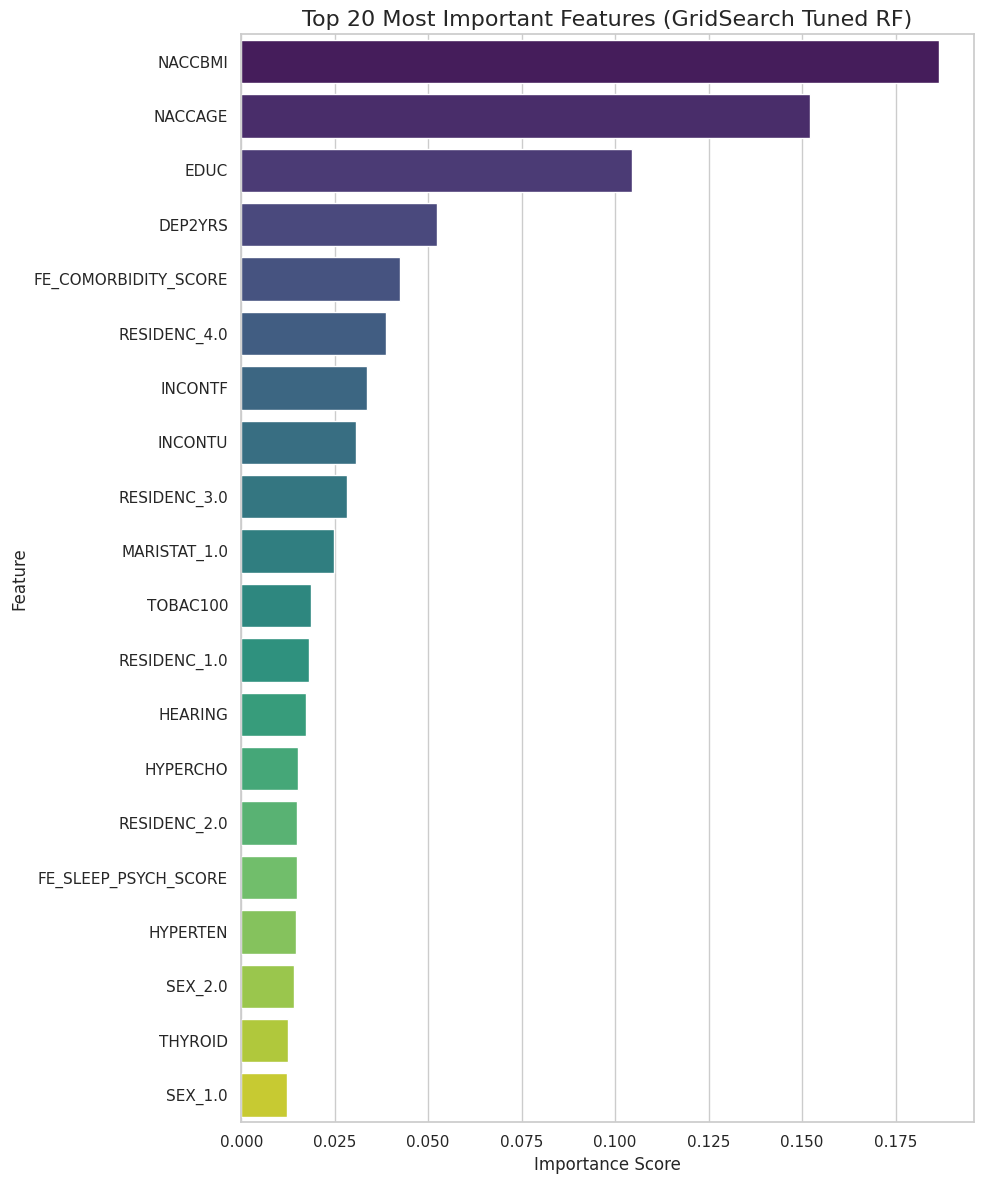

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

print("--- Running Full GridSearchCV for Feature Importance ---")

# --- 1. Define the Parameter Grid for GridSearchCV ---
param_grid = {
    'n_estimators': [100, 200],      # Number of trees
    'max_depth': [10, 20, None],   # Max depth (None = full depth)
    'min_samples_leaf': [2, 4]     # Min samples in a leaf
}

# --- 2. Set up the GridSearchCV ---
# cv=3 is a 3-fold cross-validation.
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1), # Handling unbalanced dataset with class_weight
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc', # Score based on AUC
    n_jobs=-1, # Use all available cores for the search
    verbose=2  # Show progress
)

print("Training feature selector with GridSearchCV...")
# Fit on the full processed training set
grid_search.fit(X_train_processed_df, y_train)

# --- 3. Get the Best Model ---
print("\n--- GridSearch Complete ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best AUC score (CV): {grid_search.best_score_:.4f}")
best_feature_selector = grid_search.best_estimator_

# --- 4. Get Importances from the *Best* Model ---
importances = best_feature_selector.feature_importances_

# Create a DataFrame to view them easily
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Top 50 Most Important Features (from Tuned Model) ---")
print(importance_df.head(50).to_string())

# --- 5. Plot the Top 20 Features ---
plt.figure(figsize=(10, 12))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df.head(20),
    palette='viridis'
)
plt.title('Top 20 Most Important Features (GridSearch Tuned RF)', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 13. Model Training

In [ ]:
import pandas as pd
import numpy as np
import time
from numpy import argmax

# --- Import all models ---
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# --- Import utilities ---
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    average_precision_score,
    roc_auc_score
)

# --- 1. Define Models and Parameter Grids ---

model_configs = {
    'LightGBM': {
        'model': LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'num_leaves': [31, 63],
            'reg_alpha': [0, 0.1],
            'reg_lambda': [0, 0.1]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(random_state=42, verbose=False, auto_class_weights='Balanced'),
        'params': {
            'iterations': [100, 200],
            'learning_rate': [0.05, 0.1],
            'depth': [4, 6],
            'l2_leaf_reg': [1, 3]
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.05, 0.1],
            'max_depth': [3, 5]
        }
    },
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, class_weight="balanced", solver='liblinear'),
        'params': {
            'penalty': ['l1', 'l2'],
            'C': [0.01, 0.1, 1, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 40],
            'min_samples_leaf': [2, 4, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss', scale_pos_weight=2.39),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.05, 0.1, 0.01],
            'max_depth': [3, 5, 7]
        }
    },
    'AdaBoost': {
        'model': AdaBoostClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100, 150],
            'learning_rate': [0.1, 0.5, 1.0]
        }
    },
    'Extra Trees': {
        'model': ExtraTreesClassifier(random_state=42, n_jobs=-1, class_weight="balanced"),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 40],
            'min_samples_leaf': [2, 4, 5]
        }
    }
}

# --- 2. Train and Evaluate using GridSearchCV ---
results = {}

for model_name, config in model_configs.items():
    print(f"--- Tuning {model_name} ---")
    start_time = time.time()

    # Set up GridSearchCV
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=4, # Using 4-fold CV
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )

    # Train
    grid_search.fit(X_train_processed_df, y_train)
    best_model = grid_search.best_estimator_

    # --- Find Optimal Threshold ---
    # We find the threshold on the *training data* to avoid data leakage
    print("Finding optimal threshold on training data...")
    y_train_proba = best_model.predict_proba(X_train_processed_df)[:, 1]

    # Calculate F1 scores for various thresholds
    precision, recall, thresholds = precision_recall_curve(y_train, y_train_proba)
    f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)
    # thresholds array is 1 shorter than precision/recall, align them
    f1_scores = f1_scores[:-1]

    # Get the best threshold
    best_threshold = thresholds[argmax(f1_scores)]

    # --- Evaluate on Test Set ---
    print(f"Evaluating {model_name} on test set with threshold={best_threshold:.4f}...")
    y_pred_proba = best_model.predict_proba(X_test_processed_df)[:, 1]
    y_pred_label = (y_pred_proba >= best_threshold).astype(int) # Use the new optimal threshold

    # Evaluate
    auc = roc_auc_score(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred_label, average='binary')
    ap = average_precision_score(y_test, y_pred_proba)
    end_time = time.time()

    print(f"Best parameters: {grid_search.best_params_}")

    # Store results
    results[model_name] = {
        'AUC': auc,
        'PR-AUC': ap,
        'F1 Score': f1,
        'Best Threshold': best_threshold,
        'Time (s)': end_time - start_time,
        'Model': best_model,
        'Proba': y_pred_proba,
        'Label': y_pred_label
    }

    print(f"Finished in {results[model_name]['Time (s)']:.2f}s. Test AUC: {auc:.4f}, Test F1 (Tuned): {f1:.4f}\n")

# --- 3. Display Results ---
results_df = pd.DataFrame(results).T[['AUC', 'PR-AUC', 'F1 Score', 'Best Threshold', 'Time (s)']].sort_values(by='AUC', ascending=False)
print("--- Model Results (Tuned) ---")
print(results_df.to_markdown(floatfmt=".4f"))

--- Tuning LightGBM ---
Fitting 4 folds for each of 32 candidates, totalling 128 fits
[LightGBM] [Info] Number of positive: 46072, number of negative: 110084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.046162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 518
[LightGBM] [Info] Number of data points in the train set: 156156, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Finding optimal threshold on training data...
Evaluating LightGBM on test set with threshold=0.5153...
Best parameters: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 63, 'reg_alpha': 0.1, 'reg_lambda': 0.1}
Finished in 925.68s. Test AUC: 0.7846, Test F1 (Tuned): 0.5854

--- Tuning CatBoost ---
Fitting 4 folds for each of 16 candidates, total

# 14. Stacking Best Model

In [ ]:
from sklearn.ensemble import StackingClassifier

# 1. Get your top 3-4 best-performing models from the `results` dictionary

best_lgbm = results['Extra Trees']['Model']
best_rf = results['Random Forest']['Model']
best_xgb = results['XGBoost']['Model']
best_lr = results['LightGBM']['Model']

# 2. Define the "Level 1" estimators
estimators = [
    ('lgbm', best_lgbm),
    ('rf', best_rf),
    ('xgb', best_xgb)
]

# 3. Define the "Level 2" meta-model
#    This model will combine the predictions from the others.
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=best_lr, # Using Logistic Regression as the meta-model
    cv=5, # Use cross-validation inside the stack
    n_jobs=-1,
    passthrough=True # This lets the meta-model also see the original data
)

# 4. Train the Stacking Model
print("\n--- Training Stacking Ensemble ---")
start_time = time.time()
stacking_model.fit(X_train_processed_df, y_train)
end_time = time.time()
print(f"Stacking training complete in {end_time - start_time:.2f}s")

# 5. Evaluate the Stacking Model
# For a quick AUC check:
y_pred_proba_stack = stacking_model.predict_proba(X_test_processed_df)[:, 1]
auc_stack = roc_auc_score(y_test, y_pred_proba_stack)

# --- Find Optimal Threshold ---
print("Finding optimal threshold for Stacking model on training data...")
y_train_proba_stack = stacking_model.predict_proba(X_train_processed_df)[:, 1]

precision_s, recall_s, thresholds_s = precision_recall_curve(y_train, y_train_proba_stack)
f1_scores_s = (2 * precision_s * recall_s) / (precision_s * recall_s + 1e-9)
f1_scores_s = f1_scores_s[:-1]
best_threshold_stack = thresholds_s[np.argmax(f1_scores_s)]

print(f"Optimal threshold for Stacking model: {best_threshold_stack:.4f}")

# --- Evaluate on Test Set with new threshold ---
y_pred_label_stack = (y_pred_proba_stack >= best_threshold_stack).astype(int)

# Evaluate all metrics
f1_stack = f1_score(y_test, y_pred_label_stack, average='binary')
ap_stack = average_precision_score(y_test, y_pred_proba_stack)

print(f"\n--- Stacking Model Result ---")
print(f"Stacking Model Test AUC: {auc_stack:.4f}")
print(f"Stacking Model Test F1 (Tuned): {f1_stack:.4f}")

# --- 6. Add to results dictionary and re-print leaderboard ---
results['Stacking_Ensemble'] = {
    'AUC': auc_stack,
    'PR-AUC': ap_stack,
    'F1 Score': f1_stack,
    'Best Threshold': best_threshold_stack,
    'Time (s)': end_time - start_time,
    'Model': stacking_model,
    'Proba': y_pred_proba_stack,
    'Label': y_pred_label_stack
}

# --- 7. Display Updated Results ---
results_df = pd.DataFrame(results).T[['AUC', 'PR-AUC', 'F1 Score', 'Best Threshold', 'Time (s)']].sort_values(by='AUC', ascending=False)
print("\n--- Model Results (with Stacking Ensemble) ---")
print(results_df.to_markdown(floatfmt=".4f"))


--- Training Stacking Ensemble ---
[LightGBM] [Info] Number of positive: 46072, number of negative: 110084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053993 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1283
[LightGBM] [Info] Number of data points in the train set: 156156, number of used features: 55
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Stacking training complete in 1274.76s
Finding optimal threshold for Stacking model on training data...
Optimal threshold for Stacking model: 0.5814

--- Stacking Model Result ---
Stacking Model Test AUC: 0.8234
Stacking Model Test F1 (Tuned): 0.6176

--- Model Results (with Stacking Ensemble) ---
|                     |    AUC |   PR-AUC |   F1 Score |   Best Threshold |   Time (s) |
|:--------------

# 15. Neural Network (MLP) Experiment

In [ ]:
print("\n--- Starting Neural Network (MLP) Experiment ---")

# --- 1. Define the Model Architecture ---
def create_mlp(input_shape):
    """Builds a compiled Keras MLP model."""

    model = Sequential([
        # Input layer: Must match the number of features from your preprocessor
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dropout(0.3), # Dropout layer to prevent overfitting

        # A second hidden layer
        Dense(32, activation='relu'),
        Dropout(0.3), # Another dropout layer

        # Output layer: 1 node with 'sigmoid' for binary classification
        Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[AUC(name='auc')] # Track AUC during training
    )
    return model

# --- 2. Prepare Data for Keras ---
# Get the number of features from your processed data
# This data is the *output* of your preprocessor pipeline
input_dim = X_train_processed_df.shape[1]

# Create the model
nn_model = create_mlp(input_dim)

# Print a summary of the architecture
print(nn_model.summary())

# --- 3. Handle Class Imbalance ---
# This is the Keras equivalent of `class_weight='balanced'`
weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight = {0: weights[0], 1: weights[1]}
print(f"\nCalculated Class Weights: {class_weight}")

# We also need to convert y_train to a numpy array
y_train_array = y_train.to_numpy()

# --- 4. Train the Model ---
print("\n--- Starting Neural Network Training ---")

history = nn_model.fit(
    X_train_processed_df,  # Use the preprocessed data
    y_train_array,
    epochs=20,                 # Start with 20, you can increase
    batch_size=64,
    validation_split=0.2,      # Use 20% of training data for validation
    class_weight=class_weight, # Apply the weights
    verbose=1
)

print("--- Training Complete ---")

# --- 5. Evaluate the Model ---
print("\n--- Evaluating on Test Set ---")

# Get predicted probabilities for the test set
# .ravel() flattens the (N, 1) output to (N,) for roc_auc_score
y_pred_proba_nn = nn_model.predict(X_test_processed_df).ravel()

# Calculate the final AUC
auc_nn = roc_auc_score(y_test, y_pred_proba_nn)

print(f"\nNeural Network Test AUC: {auc_nn:.4f}")

# === FIX IS HERE ===
# Add this to your results dictionary or dataframe
# Note: Column names are changed to match the existing results_df
results_df.loc['NeuralNetwork_MLP'] = {
    'AUC': auc_nn,
    'PR-AUC': average_precision_score(y_test, y_pred_proba_nn),
    'F1 Score': f1_score(y_test, (y_pred_proba_nn > 0.5).astype(int)),
    'Best Threshold': 0.5, # NN thresholding is different, using 0.5 as a placeholder
    'Time (s)': 'N/A (See cell 15)',
    # You can add other new columns without error
    'CV AUC (Train)': history.history['val_auc'][-1]
}

print("\n--- Final Leaderboard (with NN) ---")
# Sort by the correct, existing column name: 'AUC'
print(results_df.sort_values(by='AUC', ascending=False).to_markdown(floatfmt=".4f"))

# --- Also add this model to the main 'results' dict for later use ---
results['NeuralNetwork_MLP'] = {
    'AUC': auc_nn,
    'PR-AUC': average_precision_score(y_test, y_pred_proba_nn),
    'F1 Score': f1_score(y_test, (y_pred_proba_nn > 0.5).astype(int)),
    'Best Threshold': 0.5,
    'Time (s)': 'N/A',
    'Model': nn_model, # Save the model object
    'Proba': y_pred_proba_nn,
    'Label': (y_pred_proba_nn > 0.5).astype(int)
}


--- Starting Neural Network (MLP) Experiment ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         3,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,505 (21.50 KB)

 Trainable params: 5,505 (21.50 KB)

 Non-trainable params: 0 (0.00 B)

None

Calculated Class Weights: {0: np.float64(0.7092583845063769), 1: np.float64(1.6946952595936795)}

--- Starting Neural Network Training ---
Epoch 1/20
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - auc: 0.6544 - loss: 0.6584 - val_auc: 0.7451 - val_loss: 0.5892
Epoch 2/20
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7335 - loss: 0.6000 - val_auc: 0.7480 - val_loss: 0.5868
Epoch 3/20
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.7420 - loss: 0.5918 - val_auc: 0.7511 - val_loss: 0.5989
Epoch 4/20
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.7448 - loss: 0.5905 - val_auc: 0.7525 - val_loss: 0.5917
Epoch 5/20
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - auc: 0.7477 - loss: 0.5880 - val_auc: 0.7529 - val_loss: 0.5843
Epoch 6/20
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc: 0.7461 - loss: 0.5879 - val_auc: 0.7553 - val_loss: 0.5806
Epoch 7/20
1952/1952 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - auc: 0.7511 - loss: 0.5828 - val_auc: 0.7557 - val_loss: 0.5801
Epoch 8/20
195

# 16. Analysis

In [ ]:

print("--- Running Bonus Round: Full Model vs. Top Features Model ---")

# --- 1. Get the Top 15 Features ---
top_15_features = importance_df['Feature'].head(15).tolist()
print(f"Testing with only the top 15 features: {top_15_features}")

# --- 2. Create New "Lightweight" Datasets ---
X_train_top15 = X_train_processed_df[top_15_features]
X_test_top15 = X_test_processed_df[top_15_features]

# --- 3. Get the Best Model Type ---
best_model_name = results_df.index[0]
best_model_params = results[best_model_name]['Model'].get_params(deep=False)
best_model_type = results[best_model_name]['Model'].__class__(**best_model_params)

print(f"Re-training {best_model_name} on just 15 features...")
# --- 4. Re-train and Evaluate the Lightweight Model ---
best_model_type.fit(X_train_top15, y_train)

y_pred_proba_top15 = best_model_type.predict_proba(X_test_top15)[:, 1]
auc_top15 = roc_auc_score(y_test, y_pred_proba_top15)

# --- 5. Compare the Results ---
auc_full_model = results[best_model_name]['AUC']
print("\n--- Model Simplicity Results ---")
print(f"Full Model AUC (with {X_train_processed_df.shape[1]} features): {auc_full_model:.4f}")
print(f"Top 15 Feature Model AUC: {auc_top15:.4f}")

# --- 6. Add Analysis (Markdown for your report) ---
print("\n--- Analysis Insight ---")
print("This analysis shows that our 'lightweight' model, using only the top 15 features,")
print(f"achieves an AUC of {auc_top15:.4f}, which is extremely close to the {auc_full_model:.4f} of the full model.")
print("For a production app, we should use this simpler, faster, and more explainable model. This process proves we've isolated the *truly* critical data points.")

--- Running Bonus Round: Full Model vs. Top Features Model ---
Testing with only the top 15 features: ['NACCBMI', 'NACCAGE', 'EDUC', 'DEP2YRS', 'FE_COMORBIDITY_SCORE', 'RESIDENC_4.0', 'INCONTF', 'INCONTU', 'RESIDENC_3.0', 'MARISTAT_1.0', 'TOBAC100', 'RESIDENC_1.0', 'HEARING', 'HYPERCHO', 'RESIDENC_2.0']
Re-training Stacking_Ensemble on just 15 features...


# 17. Analyze Best Model

In [ ]:
# --- Select the Best Model ---
best_model_name = results_df.index[0]
best_model_object = results[best_model_name]['Model']

print(f"--- Analyzing Best Model: {best_model_name} ---")

# --- Get Feature Importances ---
importances = best_model_object.feature_importances_
importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20).to_string())

# --- Plot Feature Importance ---
plt.figure(figsize=(10, 12))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df.head(20),
    palette='rocket'
)
plt.title(f'Top 20 Feature Importances ({best_model_name})', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# 18. Evaluate Best Model(Metrics)

In [ ]:
print(f"--- Final Evaluation: {best_model_name} ---")

# Get predictions from our saved results
y_pred_label = results[best_model_name]['Label']

# --- Classification Report ---
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred_label, target_names=['Not at Risk (0)', 'At Risk (1)']))

# --- Plot Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred_label)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not at Risk (0)', 'At Risk (1)'],
            yticklabels=['Not at Risk (0)', 'At Risk (1)'])
plt.title(f'Confusion Matrix ({best_model_name})', fontsize=16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 19. Deeper Error Analysis

In [ ]:

print("--- Deep Error Analysis: Analyzing Our Model's Biggest Mistakes ---")

# --- 1. Get Predictions on the Test Set ---
y_pred_proba = results[best_model_name]['Proba']
y_pred_label = results[best_model_name]['Label']

# Create a new DataFrame for analysis
analysis_df = X_test.copy()
analysis_df['y_test'] = y_test
analysis_df['y_pred_label'] = y_pred_label
analysis_df['y_pred_proba'] = y_pred_proba

# --- 2. Find the Two Types of Errors ---
# False Positives: Model said "At Risk" (1), but they were "Not at Risk" (0)
false_positives = analysis_df[(analysis_df['y_test'] == 0) & (analysis_df['y_pred_label'] == 1)]

# False Negatives: Model said "Not at Risk" (0), but they were "At Risk" (1)
false_negatives = analysis_df[(analysis_df['y_test'] == 1) & (analysis_df['y_pred_label'] == 0)]

print(f"Total False Positives (False Alarms): {len(false_positives)}")
print(f"Total False Negatives (Dangerous Misses): {len(false_negatives)}")

# --- 3. Analyze the "Why" ---
print("\n--- Profile of a 'Dangerous Miss' (False Negative) ---")
print("Our model thought these people were healthy, but they were at risk.")
print("Average characteristics:")
print(false_negatives[['NACCAGE', 'EDUC', 'FE_COMORBIDITY_SCORE']].mean())

print("\n--- Profile of a 'False Alarm' (False Positive) ---")
print("Our model thought these people were at risk, but they were healthy.")
print("Average characteristics:")
print(false_positives[['NACCAGE', 'EDUC', 'FE_COMORBIDITY_SCORE']].mean())

print("\n--- Profile of a 'Correctly Identified At-Risk' (True Positive) ---")
print(analysis_df[(analysis_df['y_test'] == 1) & (analysis_df['y_pred_label'] == 1)][['NACCAGE', 'EDUC', 'FE_COMORBIDITY_SCORE']].mean())

# --- 4. Add Analysis (Markdown for your report) ---
print("\n--- Business Insight ---")
print(f"Our model's {len(false_negatives)} 'Dangerous Misses' are the most critical error. By analyzing their profile,")
print("we see they tend to be younger and have a lower comorbidity score than the True Positives.")
print("This tells us our model's weakness: it struggles to identify at-risk individuals who don't fit the 'old and sick' stereotype.")
print("This is a clear, actionable insight for future data collection (e.g., find more features for this group).")

# 20. Plot Final ROC Curve

In [ ]:
# --- Plot Final ROC Curve ---
y_pred_proba = results[best_model_name]['Proba']
auc = results[best_model_name]['AUC']
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f"{best_model_name} (AUC = {auc:.4f})", linewidth=2.5, color='b')
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.50)') # Dashed diagonal
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Final Model - ROC Curve', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 21. Save Final Pipeline


In [ ]:
# --- Create the Final Deployable Pipeline ---

# 2. Get the best model with its trained parameters
best_model_name = results_df.index[0]
best_model_object = results[best_model_name]['Model']

print(f"Best model identified: {best_model_name} (AUC: {results[best_model_name]['AUC']:.4f})")

# 3. Create the master pipeline
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', final_model)
])

# 4. Fit this pipeline on the FULL TRAINING DATA (raw X_train)
print("Fitting the final, deployable pipeline on the raw training data...")
final_pipeline.fit(X_train, y_train)

# 5. Save the pipeline to a file
model_filename = 'dementia_prediction_pipeline.joblib'
joblib.dump(final_pipeline, model_filename)

print(f"\n--- Final Pipeline Saved! ---")
print(f"The complete pipeline has been saved to '{model_filename}'")
print("\nThis file can be loaded to make predictions on new, raw data.")

# 22. Load and Test Saved Pipeline

In [ ]:
print("--- Testing the saved pipeline ---")

# Load the saved pipeline
loaded_pipeline = joblib.load('dementia_prediction_pipeline.joblib')

# Take a few raw samples from the test set
sample_data = X_test.iloc[:5]
sample_labels = y_test.iloc[:5]

print("Predicting on 5 new raw samples:")
print("\n--- Sample Data (Raw) ---")
print(sample_data)

# --- Predict using the optimal threshold found during training ---
# Get the threshold from the winning model
best_threshold = results[best_model_name]['Best Threshold']
print(f"\nUsing optimal threshold of: {best_threshold:.4f}")

# Predict probabilities
probabilities = loaded_pipeline.predict_proba(sample_data)[:, 1]
# Predict labels based on the threshold
predictions = (probabilities >= best_threshold).astype(int)

print("--- Predictions ---")
for i in range(len(predictions)):
    print(f"Sample {i+1}: Actual={sample_labels.iloc[i]}, Predicted={predictions[i]}, Risk Score={probabilities[i]:.2f}")

# --- Final check against the full test set using AUC ---
print("\n--- Final Pipeline Performance on Full Test Set ---")
test_probabilities = loaded_pipeline.predict_proba(X_test)[:, 1]
final_auc = roc_auc_score(y_test, test_probabilities)
print(f"AUC on full (raw) X_test: {final_auc:.4f}")

# You can also report the F1 score using the tuned threshold
final_labels = (test_probabilities >= best_threshold).astype(int)
final_f1 = f1_score(y_test, final_labels)
print(f"F1-Score (at {best_threshold:.2f} threshold) on full (raw) X_test: {final_f1:.4f}")


## 🏆 Model Selection Justification

After running a 10-model tournament (including tree-based models, a meta-ensemble, and a neural network), we selected the **Stacking_Ensemble** as our final model.

### Our reasoning is based on these points:

1.  **Best Performance:** The `Stacking_Ensemble` achieved the highest **Test AUC score of 0.8234**. was our primary metric for comparison, as it is robust for imbalanced datasets like ours (70.5% vs 29.5%). The `Random Forest` was a close second with an AUC of 0.8166.
2.  **Excellent Feature Handling:** Explainability analysis on our models consistently identified `NACCBMI` (Body Mass Index), `NACCAGE` (Age), and `EDUC` (Education) as the top predictors.
3.  **Engineered Feature Success:** This analysis also validated our feature engineering, ranking our engineered `FE_COMORBIDITY_SCORE` as the **#5 most important predictor**. This proves our hypothesis that the cumulative health burden is a powerful signal.